# [Angle closure Glaucoma Evaluation Challenge](https://age.grand-challenge.org/Details/)
## Scleral spur localization Baseline （FCN)

- To keep model training stable, images with coordinate == -1, were removed.

- For real inference, you MIGHT keep all images in val_file_path file.

## requirement install

In [ ]:
!pip install xlrd

## Zip File Extract

Assume `Training100.zip` and `Validation_ASOCT_Image.zip` are stored @ `./AGE_challenge Baseline/datasets/`

In [ ]:
!unzip -q ../datasets/Training100.zip -d ../datasets/
!unzip -q ../datasets/Validation_ASOCT_Image.zip -d ../datasets/

# Explore Data

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import cv2
import os, shutil
import pprint
import pandas as pd
from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline

In [2]:
data_root_path = "../datasets/Training100/"
xlsx_file_path = os.path.join(data_root_path, "Training100_Location.xlsx")

image_path = os.path.join(data_root_path, "ASOCT_Image")
label_file_path = os.path.join(data_root_path, "train_loc.csv")

train_file_path = os.path.join(data_root_path, "loc_train_split.csv")
val_file_path = os.path.join(data_root_path, "loc_val_split.csv")

img_save_path = os.path.join(data_root_path, "ASOCT_Image_loc")

In [3]:
xlsx_file = pd.read_excel(xlsx_file_path)
xlsx_file.to_csv(label_file_path, 
                    index=False, columns=['ASOCT_Name', 'X1', 'Y1', 'X2', 'Y2'])
xlsx_file.head()

,ASOCT_Name,Left_Label,X1,Y1,Right_Label,X2,Y2
0,T0056-10.jpg,1,228.833656,466.959601,1,1870.803864,451.592300
1,T0047-06.jpg,1,207.935545,525.938764,1,1792.231404,432.521881
2,T0066-15.jpg,0,239.372633,476.273925,0,1899.775568,501.007410
3,T0025-15.jpg,0,177.708404,545.655935,0,1862.380363,439.228928
4,T0088-06.jpg,0,285.256170,735.076014,0,1884.122651,767.858589


In [4]:
data_list = []

with open(label_file_path,'r') as f:  
    lines=csv.reader(f)  
    for key, line in enumerate(lines):  
        data_list.append(line)
        
pprint.pprint(data_list[:2])

[['ASOCT_Name', 'X1', 'Y1', 'X2', 'Y2'],
 ['T0056-10.jpg',
  '228.83365553922314',
  '466.95960107867666',
  '1870.8038638045307',
  '451.59230045548907']]


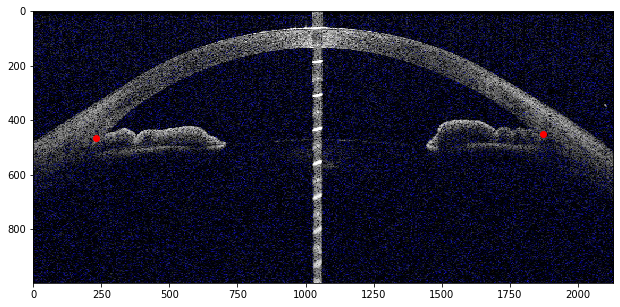

In [5]:
# visualization
plt.figure(figsize=(15,5))

file_name, l_x, l_y, r_x, r_y = data_list[1]
img = cv2.imread(os.path.join(image_path, file_name))[:,:,::-1]

plt.imshow(img)
plt.scatter(float(l_x), float(l_y), c='r')
plt.scatter(float(r_x), float(r_y), c='r')

## Center Split

Assume images.shape = nrows, ncols, channel

Especially 998, 2130, 3 for AGE dataset.

Every image is cropped to two images

- Left: [:, :nrow, :]
- Right: [:, -nrow:, :]

In [6]:
def center_split(img, l_point, r_point):
    # img: 3D nparray
    # l_point/r_point: (x,y)
    nrow, ncol, ch = img.shape
    left_img, right_img = img[:,:nrow,:], img[:,-nrow:,:]
    
#     l_point = l_point
    r_point = (r_point[0] - (ncol-nrow), r_point[1])
    return left_img, right_img, l_point, r_point

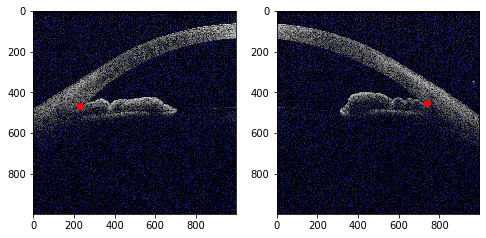

In [7]:
img = cv2.imread(os.path.join(image_path, file_name))[:,:,::-1]
left_img, right_img, l_point, r_point = \
            center_split(img, (float(l_x), float(l_y)), (float(r_x), float(r_y)))

plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.imshow(left_img)
plt.scatter(*l_point, c='r')
plt.subplot(1,2,2)
plt.imshow(right_img)
plt.scatter(*r_point, c='r')

## Prepare heatmap data for FCN model

In [8]:
def gaussian_k(x0,y0, sigma, width, height):
    """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
    """
    x = np.arange(0, width, 1, float) ## (width,)
    y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
    return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width, point, s=10):
    """ Generate a full Heap Map for every landmarks in an array
    Args:
        height    : The height of Heat Map (the height of target output)
        width     : The width  of Heat Map (the width of target output)
        point    : (x,y)
    """
    hm = gaussian_k(point[0], point[1], s, height, width)
    return hm

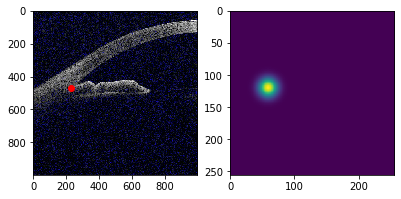

In [9]:
img = cv2.imread(os.path.join(image_path, file_name))[:,:,::-1]

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(left_img)
plt.scatter(*l_point, c='r')
plt.subplot(1,3,2)

ratio = 256.0 / img.shape[0]
img = cv2.resize(img, (256, 256))
left_hm = generate_hm(img.shape[0], img.shape[0], (l_point[0] * ratio, l_point[1] * ratio))
plt.imshow(left_hm)

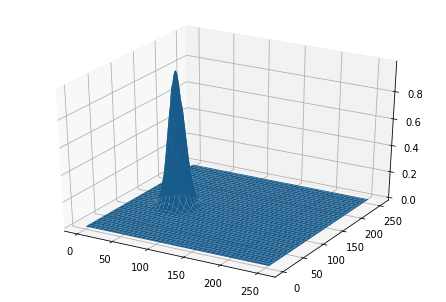

In [10]:
# 3D view of Heatmap
fig = plt.figure()
ax = Axes3D(fig)

# 生成数据
X = np.arange(0, 256, 1)
Y = np.arange(0, 256, 1)
X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, left_hm)

## Train/Val split

In [11]:
def train_val_split(data_list, train_ratio=0.8, shuffle_seed=42):
    testee_list = list(set( [line[0].split("-")[0] for line in data_list[1:]] ))
    
    val_testee_idx = np.random.choice(testee_list, int(len(testee_list) * (1-train_ratio)), replace=False)

    train_list = []
    val_list = []
    
    for line in data_list[1:]:
        file_name = line[0]
        if file_name.split("-")[0] in val_testee_idx:
            val_list.append(line)
        else:
            train_list.append(line)
            
    return train_list, val_list

In [12]:
train_data_list, val_data_list = train_val_split(data_list)
print(len(train_data_list))
print(len(val_data_list))

1296
304


## Center Split & Save

Some coordinates might be -1

In [13]:
split_train_list = []

if os.path.exists(img_save_path):
    shutil.rmtree(img_save_path)
os.mkdir(img_save_path)

for item in train_data_list:
    file_name, l_x, l_y, r_x, r_y = item
    img = cv2.imread(os.path.join(image_path, file_name))
    l_x, l_y, r_x, r_y = list(map(lambda x:float(x), [l_x, l_y, r_x, r_y]))
    # split
    left_img, right_img, l_point, r_point = center_split(img, (float(l_x), float(l_y)), (float(r_x), float(r_y)))
    
    if l_x != -1 and l_y != -1:
        cv2.imwrite(os.path.join( img_save_path, file_name.split(".")[0]+'_left.jpg'), left_img)
        split_train_list.append([file_name.split(".")[0]+'_left.jpg', *l_point])
    else:
        print(item)
    if r_x != -1 and r_y != -1:
        cv2.imwrite(os.path.join( img_save_path, file_name.split(".")[0]+'_right.jpg'), right_img)
        split_train_list.append([file_name.split(".")[0]+'_right.jpg', *r_point])
    else:
        print(item)

['T0032-02.jpg', '-1.0', '-1.0', '1843.6821495037216', '423.24170285359793']
['T0032-04.jpg', '-1.0', '-1.0', '1830.46875', '417.4608405707196']
['T0044-15.jpg', '-1.0', '-1.0', '1921.7379475363339', '842.1701745834812']
['T0032-01.jpg', '-1.0', '-1.0', '1844.5079869727044', '429.0225651364764']
['T0032-03.jpg', '-1.0', '-1.0', '1846.1596619106695', '414.98332816377166']
['T0044-14.jpg', '-1.0', '-1.0', '1911.931717476072', '850.6125930521091']


In [14]:
split_val_list = []
for item in val_data_list:
    file_name, l_x, l_y, r_x, r_y = item
    l_x, l_y, r_x, r_y = list(map(lambda x:float(x), [l_x, l_y, r_x, r_y]))
    img = cv2.imread(os.path.join(image_path, file_name))
    # split
    left_img, right_img, l_point, r_point = center_split(img, (float(l_x), float(l_y)), (float(r_x), float(r_y)))
    if l_x != -1 and l_y != -1:
        cv2.imwrite(os.path.join( img_save_path, file_name.split(".")[0]+'_left.jpg'), left_img)
        split_val_list.append([file_name.split(".")[0]+'_left.jpg', *l_point])
    else:
        print(item)
    if r_x != -1 and r_y != -1:
        cv2.imwrite(os.path.join( img_save_path, file_name.split(".")[0]+'_right.jpg'), right_img)
        split_val_list.append([file_name.split(".")[0]+'_right.jpg', *r_point])
    else:
        print(item)

['T0035-16.jpg', '-1.0', '-1.0', '1828.555184528656', '455.6486820725847']


In [15]:
with open(train_file_path, "w+") as f:
    for item in split_train_list:
        f.write("{},{},{}\n".format(*item))

with open(val_file_path, "w+") as f:
    for item in split_val_list:
        f.write("{},{},{}\n".format(*item))